## Evaluation
Notebook used for the experiments conducted for the VFX testing paper

In [2]:
# Loading the Gemini environment
import pathlib
import pickle
import random

import dotenv
import google.generativeai as genai

media = pathlib.Path("Data/Videos")

VIDEO_DIR = "Data/Videos"
SCHEMA_PATH = "Schemas/vfx_properties.json"

gemini_key = dotenv.get_key('.env', 'GEMINI_KEY')
if not gemini_key:
    raise ValueError("GEMINI_KEY environment variable not set.")
genai.configure(api_key=gemini_key)
MODEL = "gemini-1.5-pro-002"
model = genai.GenerativeModel(MODEL)

### Determining if Gemini knows the dataset
We run two experiments:

1. From a small sample of frames, we ask the model whether it knows the which game the image comes from
2. From a more representative sample of frames we determine whether the model can correctly identify the champion and the ability that is being used 

In [67]:
import numpy as np
import imageio
import cv2


def get_random_video_sample(sample_size=10):
    all_videos = {d: [file for file in f if file.endswith('webm')] for d, _, f in os.walk(VIDEO_DIR)}
    all_videos = {k: v for k, v in all_videos.items() if len(v)}
    sample = []
    for i in range(sample_size):
        random_champ = random.choice(list(all_videos.keys()))
        champ_videos = all_videos[random_champ]
        random_ability = random.choice(champ_videos)
        sample.append(os.path.join(random_champ, random_ability))
    return sample


def get_frame(video_file: str) -> np.ndarray:
    video_reader = imageio.get_reader(video_file, "ffmpeg")
    metadata = video_reader.get_meta_data()
    duration = metadata['duration']
    fps = metadata['fps']
    middle_frame_idx = int(duration // 2 * fps)

    frame = video_reader.get_data(middle_frame_idx)
    video_reader.close()
    return frame

In [55]:
import base64
import typing_extensions
import json


class WhatGame(typing_extensions.TypedDict):
    game_name: str


what_game_correct_rate = []
responses = []
for video_file in get_random_video_sample():
    frame = get_frame(video_file)
    _, jpeg_data = cv2.imencode('.jpg', frame)

    result = model.generate_content(
        [
            {'mime_type': 'image/jpeg', 'data': base64.b64encode(jpeg_data).decode('utf-8')},
            "What game is this image from?"
        ],
        generation_config=genai.GenerationConfig(response_mime_type="application/json",
                                                 response_schema=WhatGame),
    )
    what_game_correct_rate.append(json.loads(result.text)["game_name"].lower() == "League of Legends".lower())

In [71]:
import enum
import base64
import typing_extensions
import json
import cv2


class AbilityType(enum.Enum):
    PASSIVE = "P"
    Q = "Q"
    W = "W"
    E = "E"
    R = "R"


class ChampionAbility(typing_extensions.TypedDict):
    champion: str
    ability: AbilityType


champ_ability_correct_rate = []
for video_file in get_random_video_sample(100):
    frame = get_frame(video_file)
    _, jpeg_data = cv2.imencode('.jpg', frame)

    result = model.generate_content(
        [
            {'mime_type': 'image/jpeg', 'data': base64.b64encode(jpeg_data).decode('utf-8')},
            "What League of Legends champion and ability is this image showing?"
        ],
        generation_config=genai.GenerationConfig(response_mime_type="application/json",
                                                 response_schema=ChampionAbility),
    )

    response = json.loads(result.text)

    champion = response.get("champion", "").lower()
    ability = response.get("ability", "")

    gt_champ = video_file.split("/")[2].lower()
    gt_ability = video_file.split("/")[3].replace(".webm", "")[0]

    champ_ability_correct_rate.append((champion == gt_champ, ability == gt_ability))

In [88]:
NUM_CHAMPS = 169
NUM_ABILITIES = 5

random_chance_champ = (1 / NUM_CHAMPS) * len(champ_ability_correct_rate)
random_chance_ability = (1 / NUM_ABILITIES) * len(champ_ability_correct_rate)

num_champ_correct = np.array(champ_ability_correct_rate)[:, 0].sum().item()
num_ability_correct = np.array(champ_ability_correct_rate)[:, 1].sum().item()

percent_change_champ = (num_champ_correct - random_chance_champ) / random_chance_champ * 100
percent_change_ability = (num_ability_correct - random_chance_ability) / random_chance_ability * 100

percent_change_champ, percent_change_ability

(1494.3396226415095, 3.773584905660363)

### Can Gemini be used to create a GT dataset when complimented with ability information?
Get a collection of 10 random videos and manually assess them.

### How does Gemini do with determining the starts and stops of VFX?
We want to see if Gemini can determine the start and end times of a video at different FPS sampling rates.

In [118]:
VIDEO_PATH = pathlib.Path("Data/Videos")
FRAME_PATH = pathlib.Path("Data/Frames")
start_stop_gt = json.load(open("Data/GT/timing.json"))
timing_responses = {}

In [120]:
import time
import math
from google.api_core.exceptions import InvalidArgument


class StartStop(typing_extensions.TypedDict):
    start: str
    stop: str


def get_jpegs_at_fps(video_file: str, target_fps: int):
    video_reader = imageio.get_reader(video_file, "ffmpeg")
    metadata = video_reader.get_meta_data()
    video_duration = metadata['duration']
    video_fps = metadata['fps']

    total_frames = math.ceil(video_duration * video_fps)

    frame_interval = video_fps / target_fps
    frame_indices = [int(round(i * frame_interval)) for i in range(int(total_frames // frame_interval))]

    jpeg_frames = []

    for idx in frame_indices:
        try:
            frame = video_reader.get_data(idx)
            _, jpeg_data = cv2.imencode('.jpg', frame)
            jpeg_frames.append(jpeg_data.tobytes())
        except IndexError:
            break

    video_reader.close()
    return jpeg_frames

FPS = {None, 1, 3, 10}
for fps in FPS:
    for champ_ability, start_stop in start_stop_gt.items():
        if (champ_ability, fps) in timing_responses:
            continue
        video_path = str(VIDEO_PATH / champ_ability) + ".webm"
        if fps is None:  # Use generic gemini upload (has sound)
            video = genai.upload_file(video_path)
            while video.state == video.state.PROCESSING:
                time.sleep(0.01)
                video = genai.get_file(video.name)
            response = model.generate_content(
                [
                    video,
                    "In MM:ss format when does the VFX in this video start and stop, given the FPS is: 1?",
                ],
                generation_config={"response_mime_type": "application/json", "response_schema": StartStop}
            )
        else:
            frames = get_jpegs_at_fps(video_path, fps)
            image_uploads = [{'mime_type': 'image/jpeg', 'data': base64.b64encode(frame).decode('utf-8')} for frame in frames]
            seconds_format = 'MM:ss' if fps == 1 else '<seconds.fractional_seconds>'
            try: 
                response = model.generate_content(
                    [
                        *image_uploads,
                        f"In {seconds_format} format when does the VFX in this image set start and stop, given that the FPS is: {fps}?",
                    ],
                    generation_config={"response_mime_type": "application/json", "response_schema": StartStop}
                )
            except InvalidArgument:
                continue # Files are too large, to avoid cost lets just skip these and compare those that work across all

        response_json = json.loads(response.text)
        response_json["token_cost"] = response.to_dict()["usage_metadata"]["total_token_count"]
        start = response_json["start"]
        stop = response_json["stop"]
        timing_responses[(champ_ability, fps)] = {
            "start": float(start.split(":")[-1]) if fps is None or fps == 1 else float(start),
            "stop": float(stop.split(":")[-1]) if fps is None or fps == 1 else float(stop),
            "token_cost": response_json["token_cost"]
        }

In [148]:
{k[0]: val for k, val in timing_responses.items() if k[1] == 10}, start_stop_gt

({'Akali/Q1': {'start': 7.5, 'stop': 8.9, 'token_cost': 10887},
  "Bel'Veth/R1": {'start': 0.0, 'stop': 3.1, 'token_cost': 29721},
  'Graves/P1': {'start': 8.7, 'stop': 12.1, 'token_cost': 13726},
  'Graves/E1': {'start': 1.6, 'stop': 2.7, 'token_cost': 17081},
  'Rammus/E1': {'start': 1.2, 'stop': 2.5, 'token_cost': 20435},
  'Thresh/E1': {'start': 0.3, 'stop': 0.7, 'token_cost': 12179},
  'Thresh/Q1': {'start': 0.6, 'stop': 2.1, 'token_cost': 18629},
  'Warwick/P1': {'start': 0.7, 'stop': 1.1, 'token_cost': 18113},
  'Nasus/P1': {'start': 2.2, 'stop': 2.5, 'token_cost': 16565},
  'Leona/E1': {'start': 0.5, 'stop': 1.5, 'token_cost': 13207},
  'Shaco/Q1': {'start': 4.2, 'stop': 8.1, 'token_cost': 20949},
  'Kled/E1': {'start': 2.2, 'stop': 4.4, 'token_cost': 21981},
  'Singed/W1': {'start': 8.2, 'stop': 18.2, 'token_cost': 14758},
  'Aatrox/W1': {'start': 2.4, 'stop': 11.2, 'token_cost': 11406},
  'Samira/Q1': {'start': 0.8, 'stop': 2.2, 'token_cost': 17339},
  'Seraphine/R1': {'start

In [134]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from collections import defaultdict

timing_errors = defaultdict(list)

def get_video_length(video_path):
    """Retrieve the length of the video in seconds."""
    clip = VideoFileClip(video_path)
    duration = clip.duration
    clip.close()
    return duration

for key, timing_response in timing_responses.items():
    champ_ability, fps = key
    actual = start_stop_gt[champ_ability]
    start_error = abs(actual[0] - timing_response['start'])
    end_error = abs(actual[1] - timing_response['stop'])
    total = start_error + end_error
    timing_errors[fps].append({"total": total, "length_normalized": total/get_video_length(f"Data/Videos/{champ_ability}.webm")})

In [155]:
timing_errors.pop('gemini ceil')
for champ_ability, response in {k[0]: val for k, val in timing_responses.items() if k[1] is None}.items():  # Gemini Sampling
    actual = start_stop_gt[champ_ability]
    start_error = abs(round(actual[0]) - response['start'])
    end_error = abs(round(actual[1]) - response['stop'])
    total = start_error + end_error
    timing_errors['gemini ceil'].append({"total": total, "length_normalized": total/get_video_length(f"Data/Videos/{champ_ability}.webm")})

In [156]:
import numpy as np

for fps in timing_errors.keys():
    absolute_errors = [v['total'] for v in timing_errors[fps]]
    normalized_errors = [v['length_normalized'] for v in timing_errors[fps]]
    token_count = [v['token_cost'] for v in [val for k, val in timing_responses.items() if k[1] == fps]]
    print(fps,
          f"MAE: {np.mean(absolute_errors)}",
          f"Average percent error: {np.mean(normalized_errors)}",
          f"Average token count {np.mean(token_count)}")

1 MAE: 3.1820721736313566 Average percent error: 0.3542017616361051 Average token count 2044.6571428571428
10 MAE: 7.655131299831762 Average percent error: 1.219219311252828 Average token count 18370.225806451614
3 MAE: 3.936038872691934 Average percent error: 0.4606611665480636 Average token count 6295.657142857143
None MAE: 2.303890379008746 Average percent error: 0.26310285996285315 Average token count 2472.4285714285716
gemini ceil MAE: 2.2857142857142856 Average percent error: 0.26074428234320307 Average token count nan


#### Can we leverage documentation to help LLMs
Bounding box detection using VFX standards

In [175]:
from typing import List
import pickle

def normalize_coords(coords, im_shape):
    # [ymin, xmin, ymax, xmax]
    coords = np.divide(coords, 1000)
    height, width, _ = im_shape
    coords[1] *= width
    coords[3] *= width
    coords[0] *= height
    coords[2] *= height
    return np.array(coords).astype(np.int16)

class BoundingBox(typing_extensions.TypedDict):
    bounding_box: List[float]

with open("Data/GT/bb.pickle", "rb") as f:
    selected_frames = pickle.load(f)


bb_results = []
for frames in selected_frames:
    masked, image = frames
    _, masked_jpeg = cv2.imencode('.jpg', masked)
    _, original_jpeg = cv2.imencode('.jpg', image)
    
    prompt = "Provide a bounding box in [ymin, xmin, ymax, xmax] format for the VFX shown in the image"
    no_mask_prompt = [{'mime_type': 'image/jpeg', 'data': base64.b64encode(original_jpeg).decode('utf-8')}, prompt]
    
    prompt = "Provide a bounding box in [ymin, xmin, ymax, xmax] format for the VFX masked from this image"
    masked_prompt = [{'mime_type': 'image/jpeg', 'data': base64.b64encode(masked_jpeg).decode('utf-8')}, prompt]
    
    config = genai.GenerationConfig(response_mime_type="application/json", response_schema=BoundingBox)

    masked_result = model.generate_content(masked_prompt, generation_config=config)
    no_masked_result = model.generate_content(no_mask_prompt, generation_config=config)
    
    bb_results.append({
        "masked": json.loads(masked_result.text)['bounding_box'],
        "no_mask": json.loads(no_masked_result.text)['bounding_box'],
        "image": image
    })
    

In [163]:
len(bb_results)

15

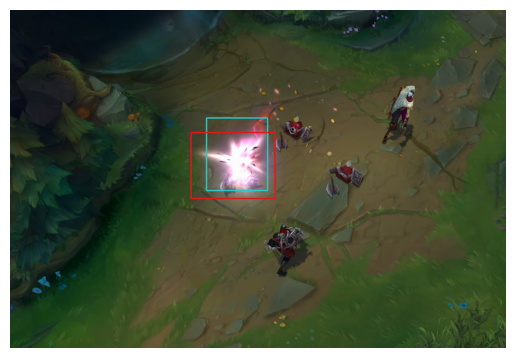

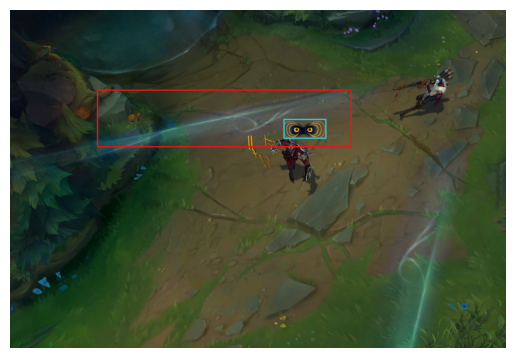

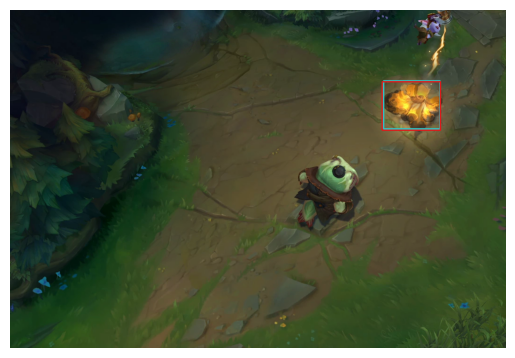

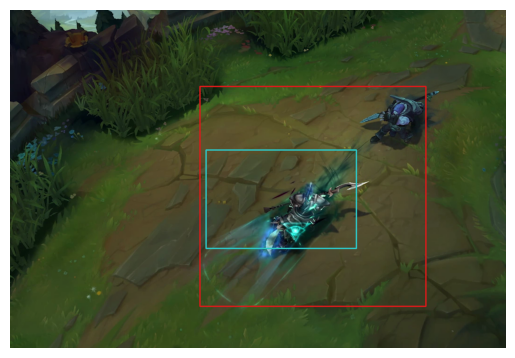

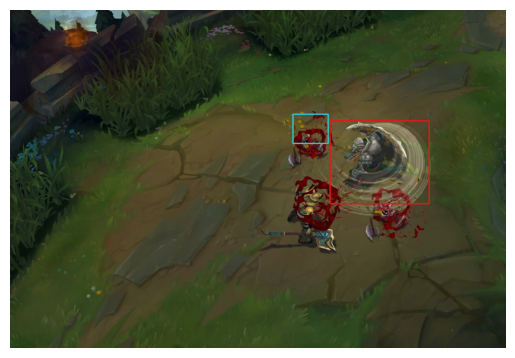

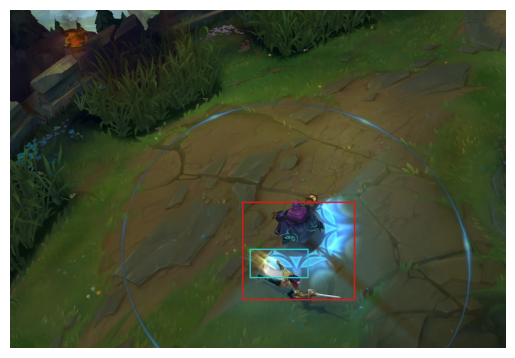

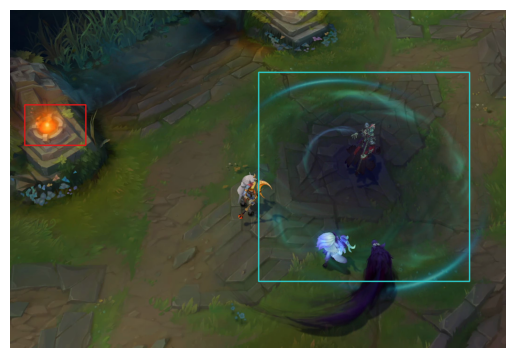

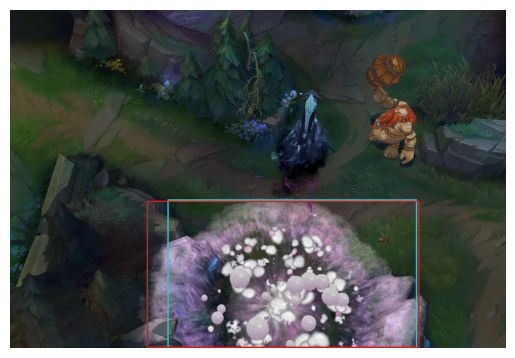

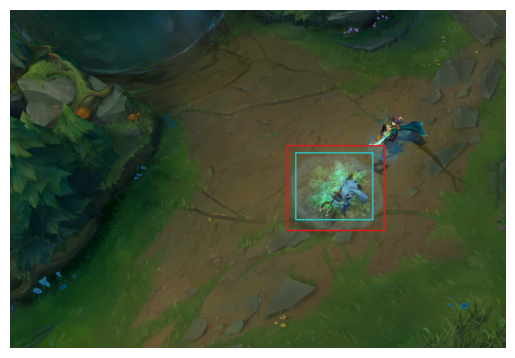

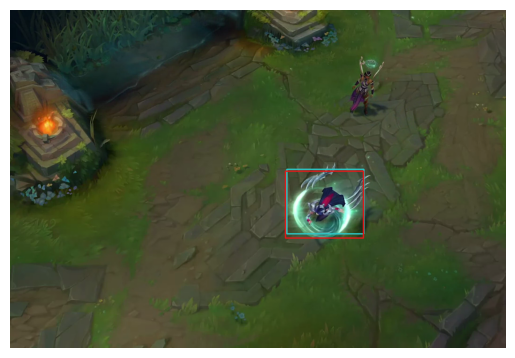

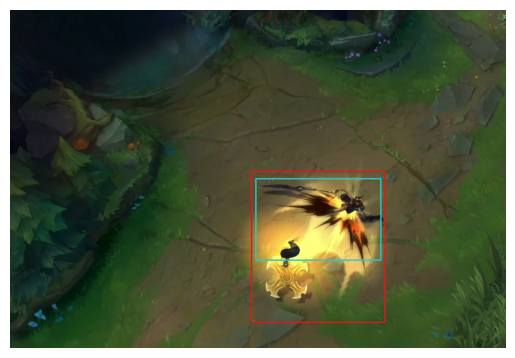

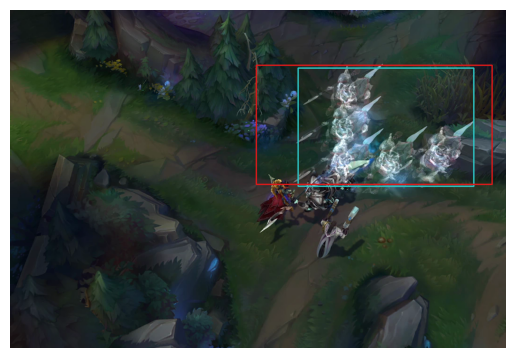

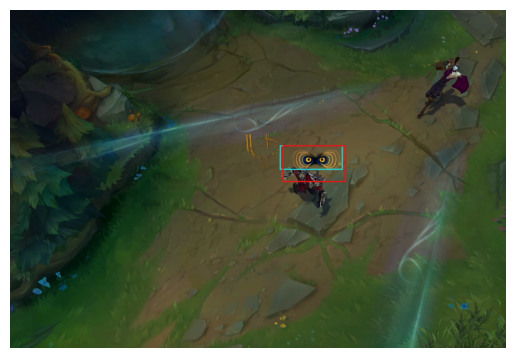

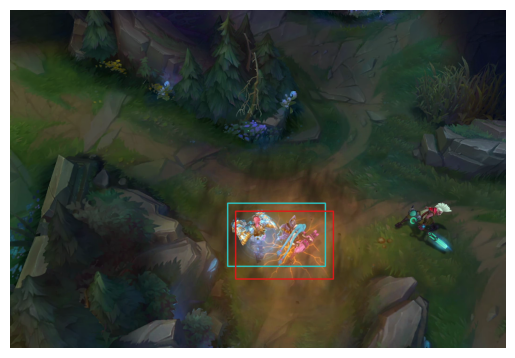

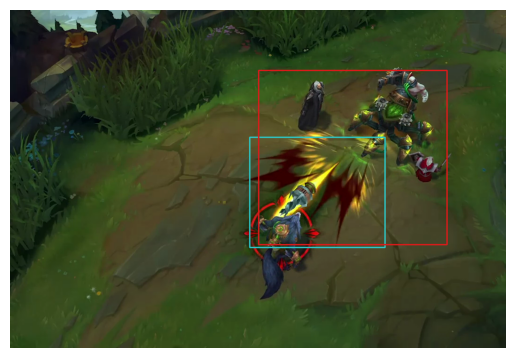

In [179]:
from matplotlib import pyplot as plt

for i, bb_result in enumerate(bb_results):
    image = bb_result['image']
    boxed = image.copy()
    bb_no_mask = normalize_coords(bb_result["no_mask"], image.shape) 
    bb_masked = normalize_coords(bb_result["masked"], image.shape)
    cv2.rectangle(boxed, (bb_no_mask[1], bb_no_mask[0]), (bb_no_mask[3], bb_no_mask[2]), (45, 200, 200), 2)
    cv2.rectangle(boxed, (bb_masked[1], bb_masked[0]), (bb_masked[3], bb_masked[2]), (222, 26, 26), 2)
    plt.imshow(boxed); plt.axis('off'); plt.show()